In [1]:
import os
import sys
%cd ..
from tqdm.auto import tqdm
import numpy as np
import time
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import clear_output
from joblib import Parallel, delayed
from utils import pkl2csv
from sklearn import metrics
from joblib import Parallel, delayed

/sise/liorrk-group/OrDanOfir/lior.exp.4


In [2]:
r = !ls temp/ensemble/*.p*
len(r)

58

In [3]:
Filtering_Algorithm = 'FWDT'
datsets_num = 20
topk=[1,2,3,4,5,10,15,20,25,30,50,100]
df = pkl2csv(Filtering_Algorithm,datsets_num,path = 'temp',topk=topk)

In [4]:
def load_all_datasets(topk,path = 'temp'):
    df0 = []
    df1 = []
    score = []
    names = []
    algo = ['FWDT','RFE_SVM','f_classif','reliefF','STG','new_STG','new_FWDT','ensemble','mrmr']
    for f in tqdm(algo):
        df = Parallel(n_jobs=int(64))(delayed(pkl2csv)(f,d,path = 'temp',topk=topk) for d in range(63))
        df0 = df0 + df
    df0 = pd.concat(df0)
    return df0

In [5]:
# if not os.path.exists("temp/results.csv"):
df = load_all_datasets(topk,path = 'temp')
    # df.to_csv("temp/results.csv",index=False)
# else:
    # df = pd.read_csv("temp/results.csv")

  0%|          | 0/9 [00:00<?, ?it/s]

/home/kaor/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


  0%|          | 0/62 [00:00<?, ?it/s]

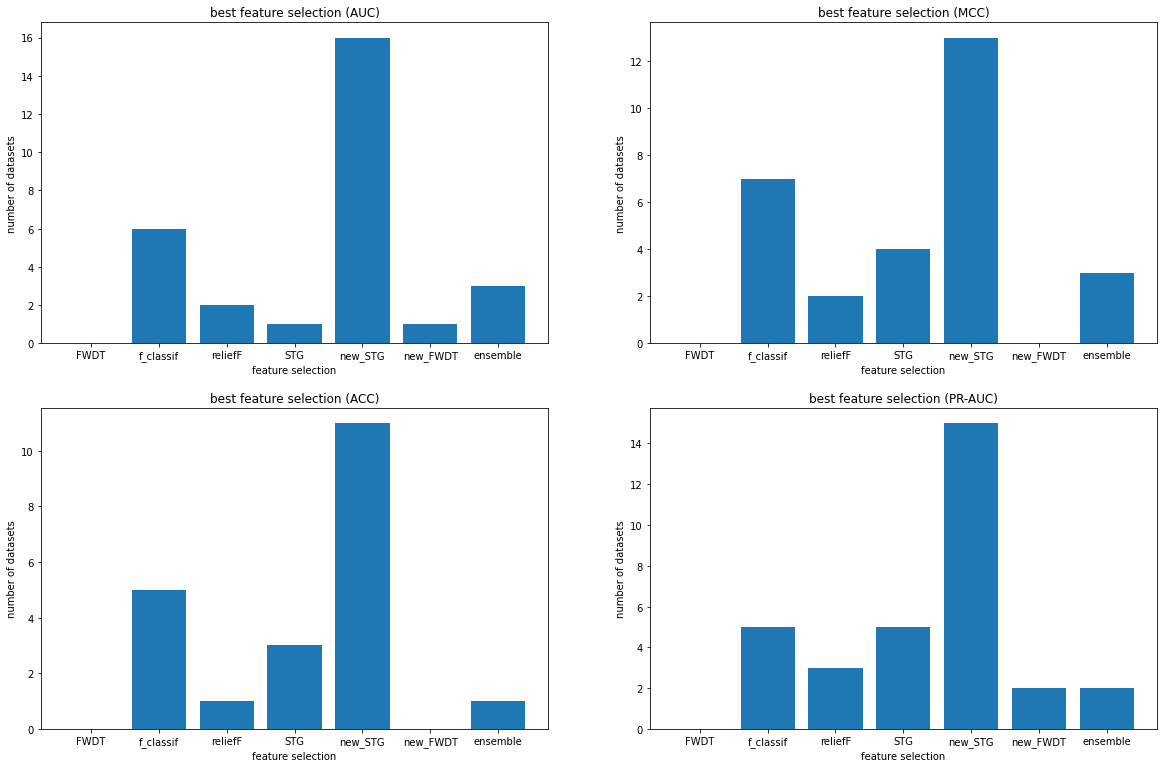

In [6]:
algo = ['FWDT','f_classif','reliefF','STG','new_STG','new_FWDT','ensemble']
datasets = []
best = []
m = []
df_mini = df[df['Fold']=="CV Score"]
for i,mini in tqdm(df_mini.groupby("Dataset Name")):
    in_data = list(set(mini['Filtering Algorithm']))
    # print(in_data)
    stop = False
    for in_d in algo:
        # print(in_d)
        if in_d not in in_data:
            # print(in_d)
            stop = True
    if stop:
        continue
    for j,mini2 in mini.groupby("Measure Type"):
        if len(mini2[mini2['Measure Value'] == mini2['Measure Value'].max()]['Filtering Algorithm'].values) > 1:
            # print("more")
            continue
        best.append(mini2[mini2['Measure Value'] == mini2['Measure Value'].max()]['Filtering Algorithm'].values[0])
        m.append(j)
        datasets.append(i)
# plt.figure(figsize=(16, 8)) 
f,ax = plt.subplots(2,2,figsize=(20,13))
for index,mm in enumerate(list(set(m))):
    datasets = np.array(datasets)
    best = np.array(best)
    m = np.array(m)
    metric = np.where(m == mm)[0]
    d = datasets[metric]
    b = best[metric]
    s = [len(b[np.where(b==bb)[0]]) for bb in algo]
    ax[index//2][index%2].bar(algo,s)
    ax[index//2][index%2].set_title(f"best feature selection ({mm})")
    ax[index//2][index%2].set_xlabel('feature selection')
    ax[index//2][index%2].set_ylabel('number of datasets')
    # plt.xticks(x_pos, bars)
plt.show()

In [7]:
def show_best(ax,algo = ['new_STG','STG'],metric='ACC',k=None):
    datasets = []
    best = []
    m = []
    df_mini = df[df['Fold']=="CV Score"]
    for i,mini in tqdm(df_mini.groupby("Dataset Name")):
        in_data = list(set(mini['Filtering Algorithm']))
        # print(in_data)
        stop = False
        for in_d in algo:
            # print(in_d)
            if in_d not in in_data:
                # print(in_d)
                stop = True
        if stop:
            continue
        if k is not None and str(k) != 'best':
            mini = mini[mini['Number of features selected (K)'] ==k]
        mini = mini[mini['Measure Type']==metric]
        df0 = mini[mini['Filtering Algorithm']==algo[0]]
        df1 = mini[mini['Filtering Algorithm']==algo[1]]
        res = df0['Measure Value'].max() - df1['Measure Value'].max() 
        best.append(res)
        m.append(j)
        datasets.append(i)
    res = np.array(best)
    names = [n.split(".csv")[0][0:7] for n in datasets]
    names = np.array(names)
    index = np.argsort(res)[::-1]
    names,res = names[index],res[index]
    index2 = np.where(res>0)[0]
    index1 = np.where(res<=0)[0]
    ax.bar(names[index2],res[index2])
    ax.bar(names[index1],res[index1])
    ax.xaxis.set_tick_params(which='both', rotation=90)
    ax.set_title(f"Show the improve: {algo[0]} vs {algo[1]} ({metric} = {round(np.mean(res),5)}) features selected (K) = {k}", fontsize=20)

In [8]:
# show_best(algo = ['new_FWDT','FWDT'],metric='ACC',k=10)
# show_best(algo = ['new_FWDT','FWDT'],metric='AUC')
# show_best(algo = ['new_FWDT','FWDT'],metric='MCC')
# show_best(algo = ['new_FWDT','FWDT'],metric='PR-AUC')

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

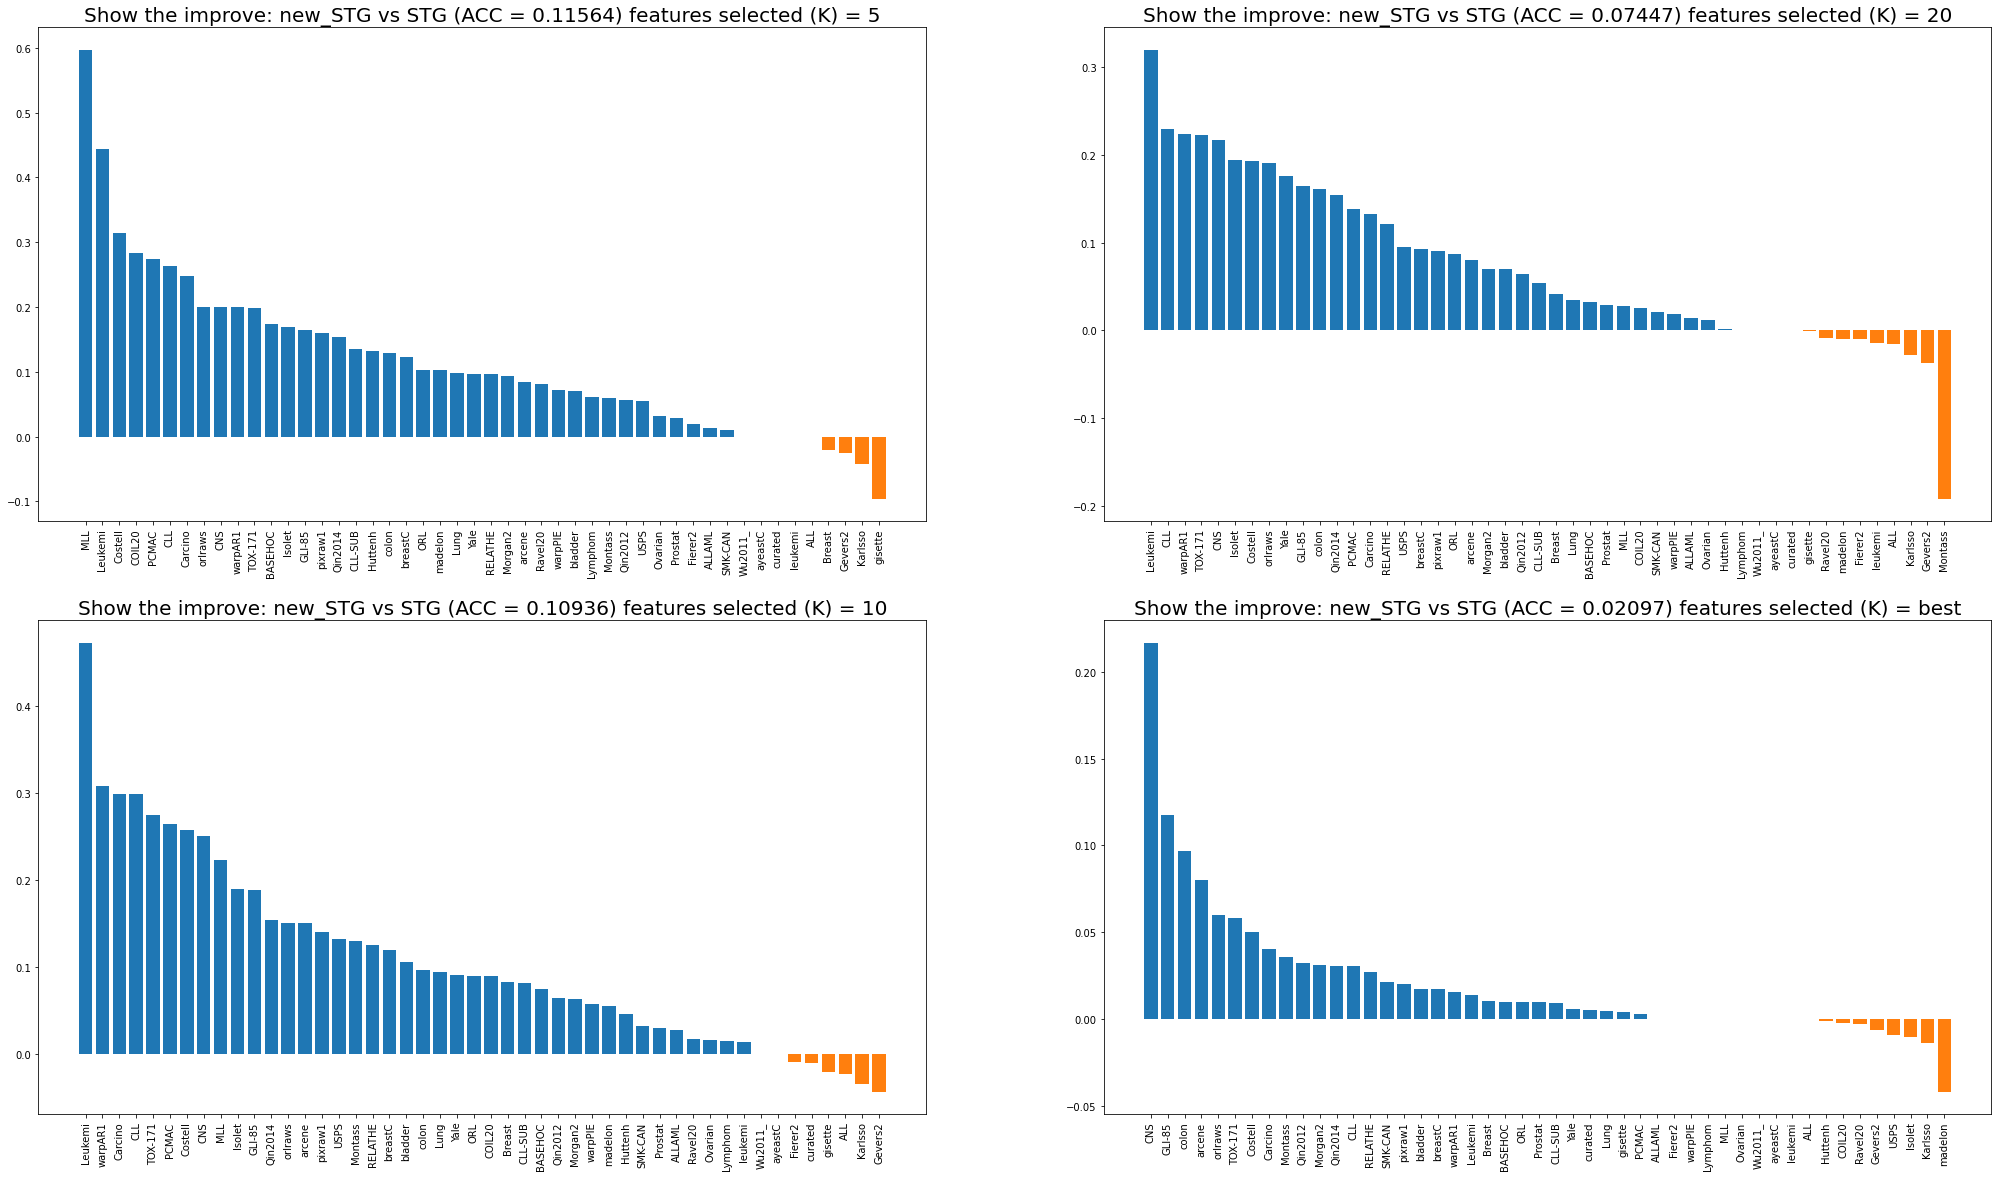

In [9]:
fig,ax = plt.subplots(2,2,figsize=(35,20))
# fig.autofmt_xdate(rotation=45)
show_best(ax[0][0],algo = ['new_STG','STG'],metric='ACC',k=5)
show_best(ax[1][0],algo = ['new_STG','STG'],metric='ACC',k=10)
show_best(ax[0][1],algo = ['new_STG','STG'],metric='ACC',k=20)
show_best(ax[1][1],algo = ['new_STG','STG'],metric='ACC',k='best')
plt.savefig("STG.png")
# show_best(algo = ['new_STG','STG'],metric='ACC',k=100)
# show_best(algo = ['new_STG','STG'],metric='AUC')
# show_best(algo = ['new_STG','STG'],metric='MCC')
# show_best(algo = ['new_STG','STG'],metric='PR-AUC')

# Comparison learning algorithm

In [10]:
Filtering_Algorithm = 'STG'
datsets_num = 0
topk=[1,2,3,4,5,10,15,20,25,30,50,100]
df_mini = pkl2csv(Filtering_Algorithm,datsets_num,path = 'temp',topk=topk)
df_mini.head()

,Dataset Name,Number of samples,Original Number of features,Filtering Algorithm,Learning algorithm,Number of features selected (K),CV Method,Fold,CV folds split,List of Selected Features Names (Long STRING),Selected Features scores,Measure Type,Measure Value,Learning algorithm train time,Learning algorithm predict proba time,Filtering algorithm time
0,Breast.csv,97,24482,STG,knn,1,LOOCV (leave-one-out),CV Score,97,[NM_004962],[0.49077708],ACC,0.628866,0.729694,0.328753,11.388346
1,Breast.csv,97,24482,STG,knn,1,LOOCV (leave-one-out),CV Score,97,[NM_004962],[0.49077708],MCC,0.264291,0.729694,0.328753,11.388346
2,Breast.csv,97,24482,STG,knn,1,LOOCV (leave-one-out),CV Score,97,[NM_004962],[0.49077708],AUC,0.662830,0.729694,0.328753,11.388346
3,Breast.csv,97,24482,STG,knn,1,LOOCV (leave-one-out),CV Score,97,[NM_004962],[0.49077708],PR-AUC,0.594104,0.729694,0.328753,11.388346
4,Breast.csv,97,24482,STG,rf,1,LOOCV (leave-one-out),CV Score,97,[NM_004962],[0.49077708],ACC,0.659794,2.565577,0.461049,11.388346


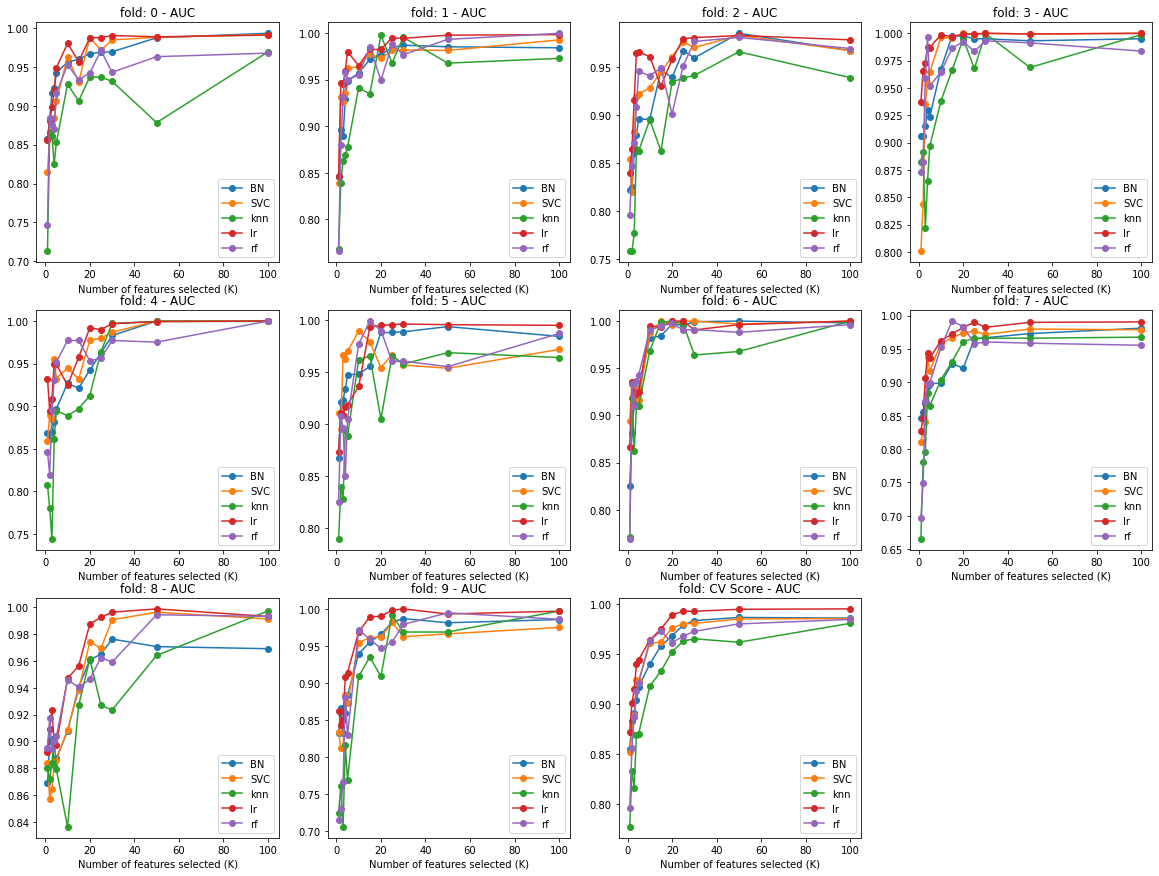

In [11]:
Filtering_Algorithm = 'STG'
datsets_num = 4
topk=[1,2,3,4,5,10,15,20,25,30,50,100]
df_mini = pkl2csv(Filtering_Algorithm,datsets_num,path = 'temp',topk=topk)
plt.figure(figsize=[20,15])
metric = 'AUC'
z = 0
for t,history_fold in df_mini.groupby("Fold"):
    z+=1
    plt.subplot(3,4,z)
    for i,mini_df in history_fold.groupby("Learning algorithm"):
        mini_df = mini_df.sort_values("Number of features selected (K)")
        mini_df = mini_df.set_index("Number of features selected (K)")
        mini_df = mini_df[mini_df['Measure Type']==metric]
        plt.plot(mini_df[['Measure Value']],label=i,marker='o')
    plt.xlabel(r'Number of features selected (K)', fontsize=10)
    # plt.ylabel(f'{metric}', fontsize=10)
    plt.title(f"fold: {t} - {metric}")
    plt.legend()
plt.show()

# Comparison of filtering algorithm on CV Score with best learning algorithm

FWDT
RFE_SVM
f_classif
reliefF
STG
new_STG
mrmr
new_FWDT
ensemble


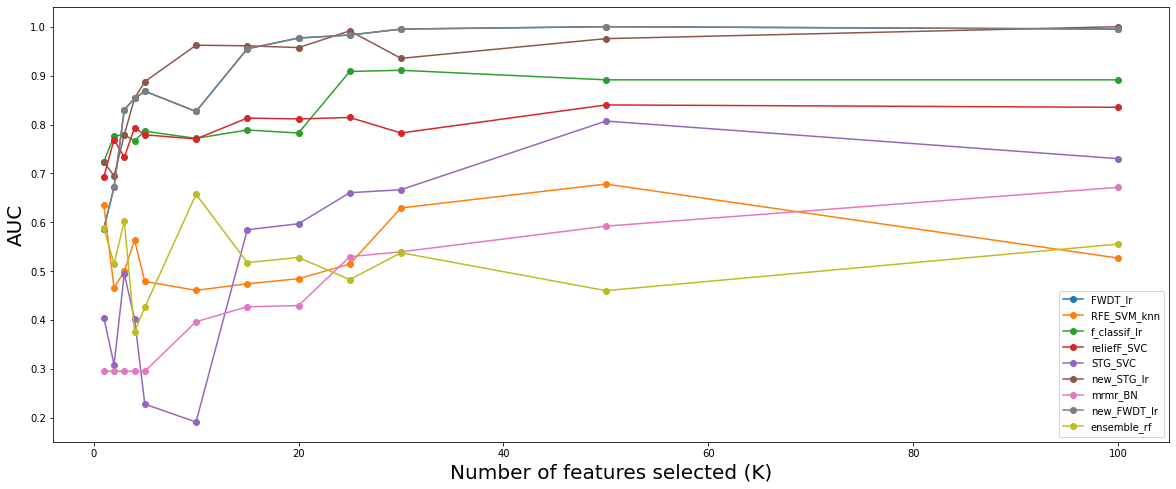

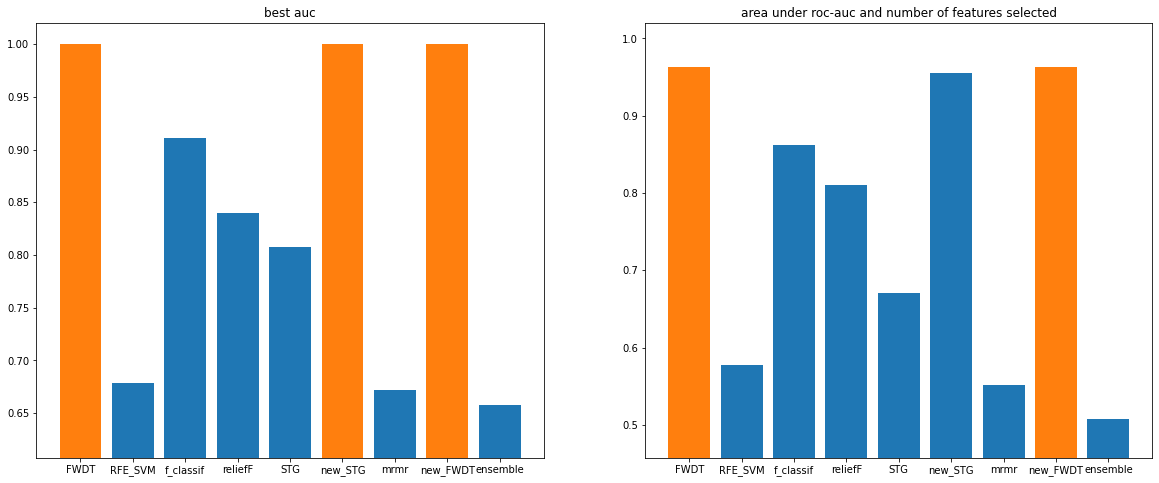

In [12]:
d = ['FWDT','RFE_SVM','f_classif','reliefF','STG','new_STG','mrmr','new_FWDT','ensemble']
plt.figure(figsize=[20,8])
metric = 'AUC'
bars = []
names = []
auc = []
datsets_num = 1
for row in d:
    print(row)
    history_summary_old = pkl2csv(row,datsets_num,path = 'temp',topk=topk)
    history_summary_old = history_summary_old[history_summary_old['Fold']=='CV Score']
    history_summary_old = history_summary_old[history_summary_old['Measure Type']==metric]
    best = list(history_summary_old[history_summary_old['Measure Value'] == history_summary_old['Measure Value'].max()]["Learning algorithm"])[0]
    history_summary_old = history_summary_old[history_summary_old['Learning algorithm'] == best]
    bars.append(float(history_summary_old[['Measure Value']].max()))
    names.append(row)
    for i,mini_df in history_summary_old.groupby("Learning algorithm"):
        mini_df = mini_df.sort_values("Number of features selected (K)")
        mini_df = mini_df.set_index("Number of features selected (K)")
        mini_df = mini_df[mini_df['Measure Type']==metric]
        auc.append(metrics.auc(np.array(list(mini_df.index))/100,np.array(list(mini_df['Measure Value']))))
        plt.plot(mini_df[['Measure Value']],label=f'{row}_{i}',marker='o')
    
plt.legend()
plt.ylabel(f'{metric}', fontsize=20)
# plt.title(metric)
plt.xlabel(r'Number of features selected (K)', fontsize=20)
plt.show()
plt.figure(figsize=[20,8])
plt.subplot(121)
plt.bar(names,bars)
m = np.max(bars)
index = list(np.where(bars==m)[0])
bars = np.array(bars)
names = np.array(names)
plt.bar(names[index],bars[index])
plt.ylim(np.min(bars)-0.05,1.02)
plt.title("best auc")
plt.subplot(122)
plt.bar(names,auc)
m = np.max(auc)
index = list(np.where(auc==m)[0])
auc = np.array(auc)
names = np.array(names)
plt.bar(names[index],auc[index])
plt.ylim(np.min(auc)-0.05,1.02)
plt.title("area under roc-auc and number of features selected")
plt.show()